
# SQL Primer: Taxi Trip Data Example
##     Accessing KDC Data from Python    

### Main Questions: Are Taxi Rides Faster on Sunny Days? 
### 1.) Import Taxi Data from KDC
### 2.) Reformat Data to Answer Question
### 3.) Run a Linear Regression and Graph Results


In [ ]:
### Connecting on KLC ####

# from a GNOME terminal session in FastX, type the following

# module load python/anaconda3.6
# module load firefox/62
# conda create -n taxi_env python=3.6
# source activate taxi_env
# conda install -c conda-forge pyodbc
# jupyter notebook --browser=firefox

# 1.) Import the Taxi Data

In [1]:
# import and load packages

import os
import pyodbc
import textwrap
from getpass import getpass
import pandas as pd
import numpy as np
from sklearn import linear_model
import seaborn as sns; sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

try:
    os.environ['ODBCSYSINI']
except KeyError:
    os.environ['ODBCSYSINI']='/home/<your_netID>/.odbc'

In [ ]:
# get KDC02 credentials

USER = 'kellogg\\<your_netID>'
PASSWORD = getpass()

In [ ]:
# establish KDC02 connection and cursor

conn = pyodbc.connect('DSN=kdc-tds;Database=TAXI_NYC;UID='+USER+';PWD='+PASSWORD)
cursor = conn.cursor()

In [ ]:
# count observations/rows

cursor.execute("SELECT COUNT(*) FROM TAXI_NYC.dbo.SRC_FareData")
taxi_fare_count = cursor.fetchone()[0]
print(taxi_fare_count)

cursor.execute("SELECT COUNT(*) FROM TAXI_NYC.dbo.SRC_TripData")
taxi_trip_count = cursor.fetchone()[0]
print(taxi_trip_count)

In [ ]:
# Preview the first 1000 Observations

cursor.execute("SELECT TOP 1000 * FROM TAXI_NYC.dbo.SRC_FareData")
taxi_fare = cursor.fetchall()
cursor.execute("SELECT TOP 1000 * FROM TAXI_NYC.dbo.SRC_TripData")
taxi_trip = cursor.fetchall()

In [ ]:
# Join the Fare and Trip Datasets for trips on specific dates, 5/20/13
sql1 = textwrap.dedent("""
  SELECT TOP 1000 
    Trip.hack_license,
    Trip.medallion,
    Trip.vendor_id,
    Trip.pickup_datetime,
    Trip.dropoff_datetime,
    Trip.trip_distance,
    Trip.trip_time_in_secs,
    Trip.passenger_count,
    Fare.[ fare_amount] 
    FROM TAXI_NYC.dbo.SRC_TripData as Trip
    LEFT OUTER JOIN TAXI_NYC.dbo.SRC_FareData as Fare
    ON (Trip.hack_license = Fare.[ hack_license])
    AND (Trip.medallion = Fare.medallion)
    AND (Trip.vendor_id = Fare.[ vendor_id])
    AND (Trip.pickup_datetime = Fare.[ pickup_datetime])
    WHERE Trip.pickup_datetime LIKE '2013-05-20%'
    ORDER BY Trip.pickup_datetime
    
""")

In [ ]:
#read results into pandas dataframe

taxi1 = pd.read_sql(sql1,conn)
taxi1[:5]

In [ ]:
sql2 = textwrap.dedent("""
  SELECT TOP 1000 
    Trip.hack_license,
    Trip.medallion,
    Trip.vendor_id,
    Trip.pickup_datetime,
    Trip.dropoff_datetime,
    Trip.trip_distance,
    Trip.trip_time_in_secs,
    Trip.passenger_count,
    Fare.[ fare_amount] 
    FROM TAXI_NYC.dbo.SRC_TripData as Trip
    LEFT OUTER JOIN TAXI_NYC.dbo.SRC_FareData as Fare
    ON (Trip.hack_license = Fare.[ hack_license])
    AND (Trip.medallion = Fare.medallion)
    AND (Trip.vendor_id = Fare.[ vendor_id])
    AND (Trip.pickup_datetime = Fare.[ pickup_datetime])
    WHERE Trip.pickup_datetime LIKE '2013-06-20%'
    ORDER BY Trip.pickup_datetime
    
""")

taxi2 = pd.read_sql(sql2,conn)
taxi2[:5]

In [ ]:
# Combine dataframes
taxi = [taxi1, taxi2]
taxi = pd.concat(taxi)
len(taxi) # number or rows/observations

In [10]:
# Just in case the query takes too long, read in the dataframe
taxi = pd.read_csv("taxi_backup.csv")
len(taxi)
taxi.head()

,hack_license,medallion,vendor_id,pickup_datetime,dropoff_datetime,trip_distance,trip_time_in_secs,passenger_count,fare_amount
0,AEEAB153BDE0C9328AD310E0AE0C50B7,BFC7B5658240F0BF73C7FBA5B3B5F338,VTS,2013-05-20 00:00:00,2013-05-20 00:10:00,3.20,600,1,12.0
1,E4EE74263ADA909E3175B2A656D7D316,BF8BB94FEEB5C6D1F499351E960EF92A,VTS,2013-05-20 00:00:00,2013-05-20 00:10:00,2.24,600,1,10.0
2,437F8DAC25396805E38BAA7D63F3F2F8,D7BE8487A5ED42E6A829A642B320EE4B,VTS,2013-05-20 00:00:00,2013-05-20 00:17:00,5.26,1020,5,17.5
3,B42E1830F2F15BF9B81FA2A00E1D7606,C1B8772F6103A4C4B3EE6F93F0360688,VTS,2013-05-20 00:00:00,2013-05-20 00:24:00,12.43,1440,6,52.0
4,018B84B770A384B90785D0CBDE32401E,980B554CAEC3E2C077D905EC4A286EE4,VTS,2013-05-20 00:00:00,2013-05-20 00:12:00,7.04,720,2,20.5


# 2.) Reformat the Data to Answer Question

In [11]:
# print column list
print(list(taxi))

# remove invalid time observations
taxi['trip_time_in_secs'] = pd.to_numeric(taxi['trip_time_in_secs'])
taxi = taxi[taxi.trip_time_in_secs > 0]
len(taxi)

['hack_license', 'medallion', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'trip_distance', 'trip_time_in_secs', 'passenger_count', ' fare_amount']


1992

In [12]:
# separate pickup and dropoff date and time into two varaibles
taxi.rename(columns = {'pickup_datetime':'pickup'}, inplace = True) 
taxi.rename(columns = {'dropoff_datetime':'dropoff'}, inplace = True) 

taxi[['pickup_date','pickup_time']] = taxi.pickup.str.split(" ",expand=True)
taxi[['dropoff_date','dropoff_time']] = taxi.dropoff.str.split(" ",expand=True)

taxi.head()

,hack_license,medallion,vendor_id,pickup,dropoff,trip_distance,trip_time_in_secs,passenger_count,fare_amount,pickup_date,pickup_time,dropoff_date,dropoff_time
0,AEEAB153BDE0C9328AD310E0AE0C50B7,BFC7B5658240F0BF73C7FBA5B3B5F338,VTS,2013-05-20 00:00:00,2013-05-20 00:10:00,3.20,600,1,12.0,2013-05-20,00:00:00,2013-05-20,00:10:00
1,E4EE74263ADA909E3175B2A656D7D316,BF8BB94FEEB5C6D1F499351E960EF92A,VTS,2013-05-20 00:00:00,2013-05-20 00:10:00,2.24,600,1,10.0,2013-05-20,00:00:00,2013-05-20,00:10:00
2,437F8DAC25396805E38BAA7D63F3F2F8,D7BE8487A5ED42E6A829A642B320EE4B,VTS,2013-05-20 00:00:00,2013-05-20 00:17:00,5.26,1020,5,17.5,2013-05-20,00:00:00,2013-05-20,00:17:00
3,B42E1830F2F15BF9B81FA2A00E1D7606,C1B8772F6103A4C4B3EE6F93F0360688,VTS,2013-05-20 00:00:00,2013-05-20 00:24:00,12.43,1440,6,52.0,2013-05-20,00:00:00,2013-05-20,00:24:00
4,018B84B770A384B90785D0CBDE32401E,980B554CAEC3E2C077D905EC4A286EE4,VTS,2013-05-20 00:00:00,2013-05-20 00:12:00,7.04,720,2,20.5,2013-05-20,00:00:00,2013-05-20,00:12:00


In [13]:
# create miles per hour variable
taxi['trip_distance'] = pd.to_numeric(taxi['trip_distance'])
taxi['passenger_count'] = taxi['passenger_count'].astype(int)
taxi['trip_MPH'] = taxi.trip_distance/((taxi.trip_time_in_secs/60)/60)
taxi = taxi[(taxi.trip_MPH < 75) & (taxi.passenger_count < 5)]

taxi.head()

,hack_license,medallion,vendor_id,pickup,dropoff,trip_distance,trip_time_in_secs,passenger_count,fare_amount,pickup_date,pickup_time,dropoff_date,dropoff_time,trip_MPH
0,AEEAB153BDE0C9328AD310E0AE0C50B7,BFC7B5658240F0BF73C7FBA5B3B5F338,VTS,2013-05-20 00:00:00,2013-05-20 00:10:00,3.20,600,1,12.0,2013-05-20,00:00:00,2013-05-20,00:10:00,19.200000
1,E4EE74263ADA909E3175B2A656D7D316,BF8BB94FEEB5C6D1F499351E960EF92A,VTS,2013-05-20 00:00:00,2013-05-20 00:10:00,2.24,600,1,10.0,2013-05-20,00:00:00,2013-05-20,00:10:00,13.440000
4,018B84B770A384B90785D0CBDE32401E,980B554CAEC3E2C077D905EC4A286EE4,VTS,2013-05-20 00:00:00,2013-05-20 00:12:00,7.04,720,2,20.5,2013-05-20,00:00:00,2013-05-20,00:12:00,35.200000
5,41486244CD1CFE0AE7CB62FDD63D4EF9,FAB5D794DA58398B8716099C3D113F7E,VTS,2013-05-20 00:00:00,2013-05-20 00:09:00,3.56,540,1,12.0,2013-05-20,00:00:00,2013-05-20,00:09:00,23.733333
6,7FBDEDA148F281D75DD1022A35C50BBE,4D9B12EA20D314D0A414D7FE1EEE4FE4,VTS,2013-05-20 00:00:00,2013-05-20 00:15:00,2.89,900,1,12.5,2013-05-20,00:00:00,2013-05-20,00:15:00,11.560000


In [14]:
# merge taxi and weather data
 
weather_data = {'pickup_date':['2013-05-20', '2013-06-20'], 'condition':['sunny', 'cloudy/rain']} 
weather = pd.DataFrame(weather_data)
weather
    
taxi = pd.merge(taxi, weather, on="pickup_date")
taxi.head()


,hack_license,medallion,vendor_id,pickup,dropoff,trip_distance,trip_time_in_secs,passenger_count,fare_amount,pickup_date,pickup_time,dropoff_date,dropoff_time,trip_MPH,condition
0,AEEAB153BDE0C9328AD310E0AE0C50B7,BFC7B5658240F0BF73C7FBA5B3B5F338,VTS,2013-05-20 00:00:00,2013-05-20 00:10:00,3.20,600,1,12.0,2013-05-20,00:00:00,2013-05-20,00:10:00,19.200000,sunny
1,E4EE74263ADA909E3175B2A656D7D316,BF8BB94FEEB5C6D1F499351E960EF92A,VTS,2013-05-20 00:00:00,2013-05-20 00:10:00,2.24,600,1,10.0,2013-05-20,00:00:00,2013-05-20,00:10:00,13.440000,sunny
2,018B84B770A384B90785D0CBDE32401E,980B554CAEC3E2C077D905EC4A286EE4,VTS,2013-05-20 00:00:00,2013-05-20 00:12:00,7.04,720,2,20.5,2013-05-20,00:00:00,2013-05-20,00:12:00,35.200000,sunny
3,41486244CD1CFE0AE7CB62FDD63D4EF9,FAB5D794DA58398B8716099C3D113F7E,VTS,2013-05-20 00:00:00,2013-05-20 00:09:00,3.56,540,1,12.0,2013-05-20,00:00:00,2013-05-20,00:09:00,23.733333,sunny
4,7FBDEDA148F281D75DD1022A35C50BBE,4D9B12EA20D314D0A414D7FE1EEE4FE4,VTS,2013-05-20 00:00:00,2013-05-20 00:15:00,2.89,900,1,12.5,2013-05-20,00:00:00,2013-05-20,00:15:00,11.560000,sunny


# 3.) Run a regression and graph results

In [15]:
# create objects for outcome and predictor variables
y = taxi["trip_MPH"]
condition_dummy = pd.get_dummies(taxi['condition'])
taxi = pd.concat([taxi, condition_dummy], axis=1)

X = taxi[['passenger_count', 'sunny']]
X[:5]

,passenger_count,sunny
0,1,1
1,1,1
2,2,1
3,1,1
4,1,1


In [16]:
# run the regression
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
print(model.coef_)

[-0.43556827  3.83913338]


/software/anaconda3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


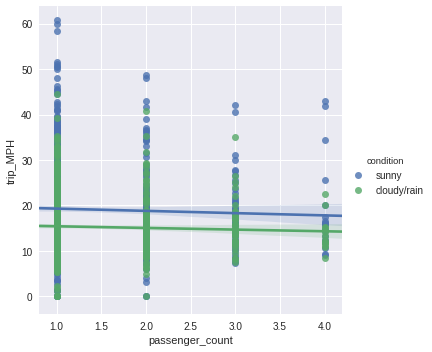

In [17]:
# graph the results
g = sns.lmplot(x="passenger_count", y="trip_MPH", hue="condition", data=taxi)